# ASUM-DM Methodology Analysis - Caso 1: Clustering

## 1. Etapas de Entendimiento

### 1.1 Comprensión del Negocio
**Objetivo:** Definir el problema, los objetivos de negocio y los requisitos de la solución.

**Problema:** Una empresa de retail busca implementar estrategias de marketing diferenciadas segmentando a sus clientes según su comportamiento.

**Objetivo de Negocio:** Confirmar o rechazar la hipótesis del equipo de mercadeo de que los clientes se pueden dividir en **3 grupos**.

### 1.2 Enfoque Analítico
**Tipo de Problema:** Aprendizaje no supervisado (Clustering).

**Métodos de Construcción:** Se utilizarán y compararán cuatro algoritmos de agrupamiento:
1. **K-Means:** Método de partición basado en centroides
2. **Método Jerárquico Aglomerativo (MJA):** Clustering jerárquico con dendrogramas
3. **DBSCAN:** Método basado en densidad
4. **Gaussian Mixture Models (GMM):** Método basado en distribución probabilística

## 2. Etapas de Preparación

### 2.1 Recopilación y Carga de Datos

In [5]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('..'))

from utils.entrega1.data_loader import load_data

df = load_data('../data/datos_caso_1.csv')
df.info()

Data loaded successfully with shape: (2240, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int

### 2.2 Comprensión de Datos - Análisis Exploratorio (EDA)

#### Estadísticas Básicas

In [6]:
from utils.entrega1.eda import get_basic_stats

display(get_basic_stats(df).T)

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


#### Valores Faltantes

<Figure size 1000x600 with 0 Axes>

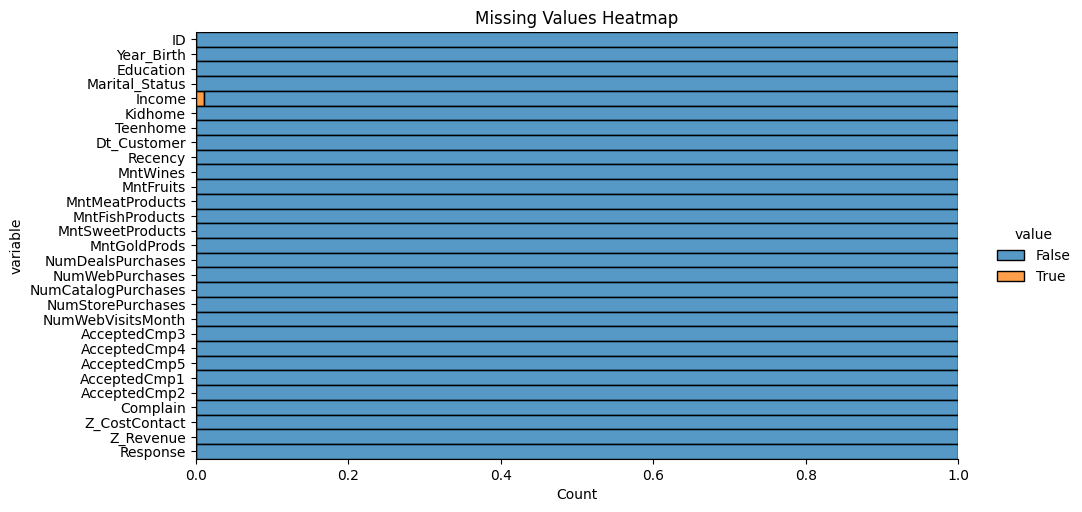

In [7]:
from utils.entrega1.eda import check_missing_values_viz

check_missing_values_viz(df)

#### Distribuciones de Variables Numéricas

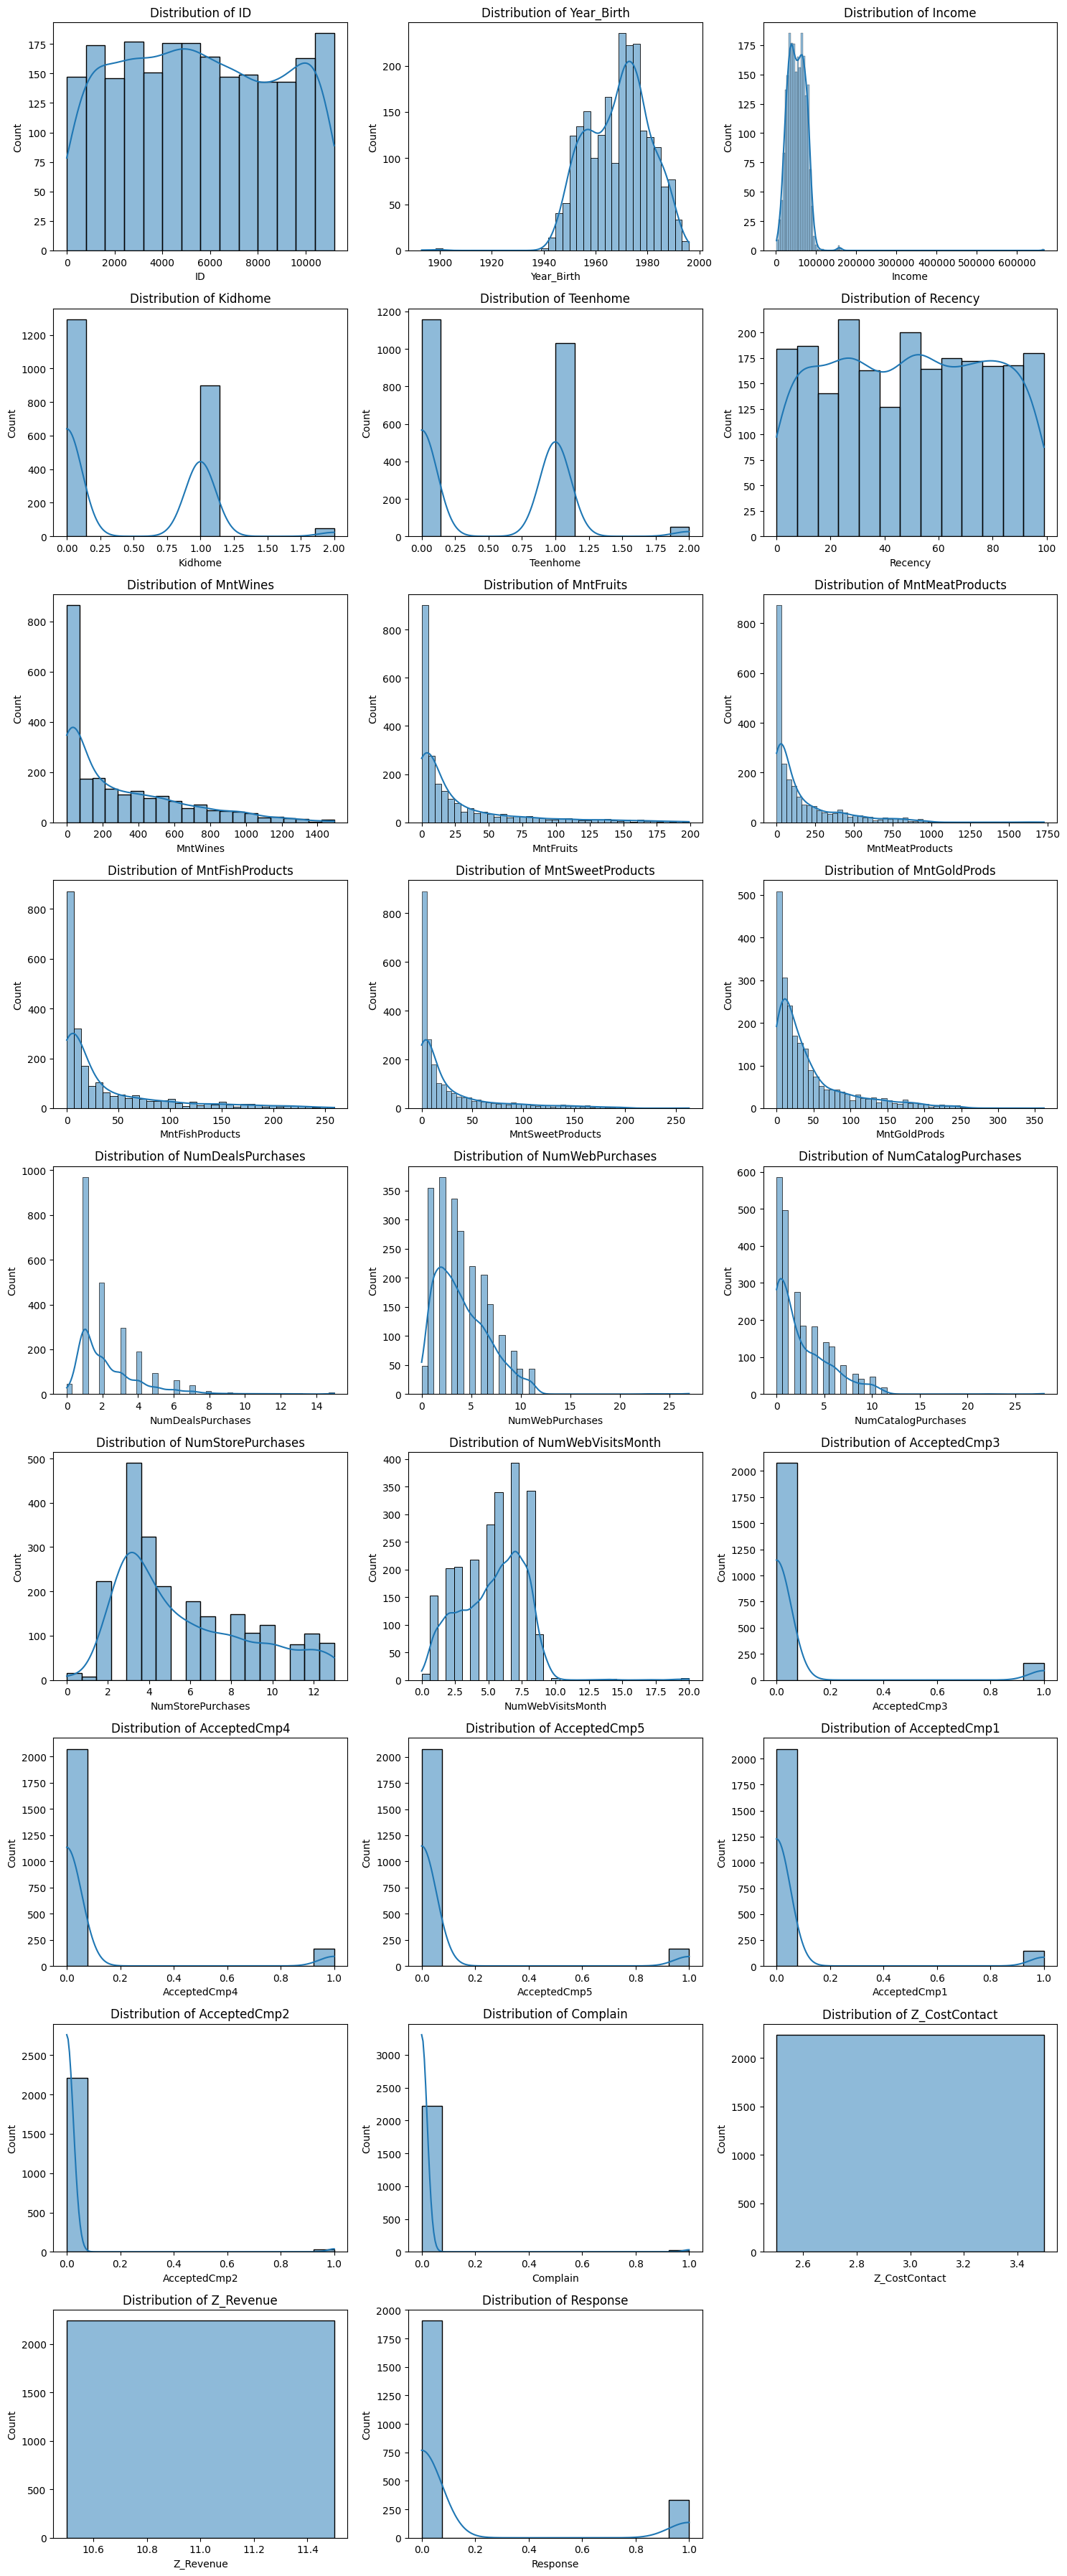

In [8]:
from utils.entrega1.eda import plot_distributions_numerical

numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
plot_distributions_numerical(df, numerical_cols)

#### Boxplots para Detección de Outliers

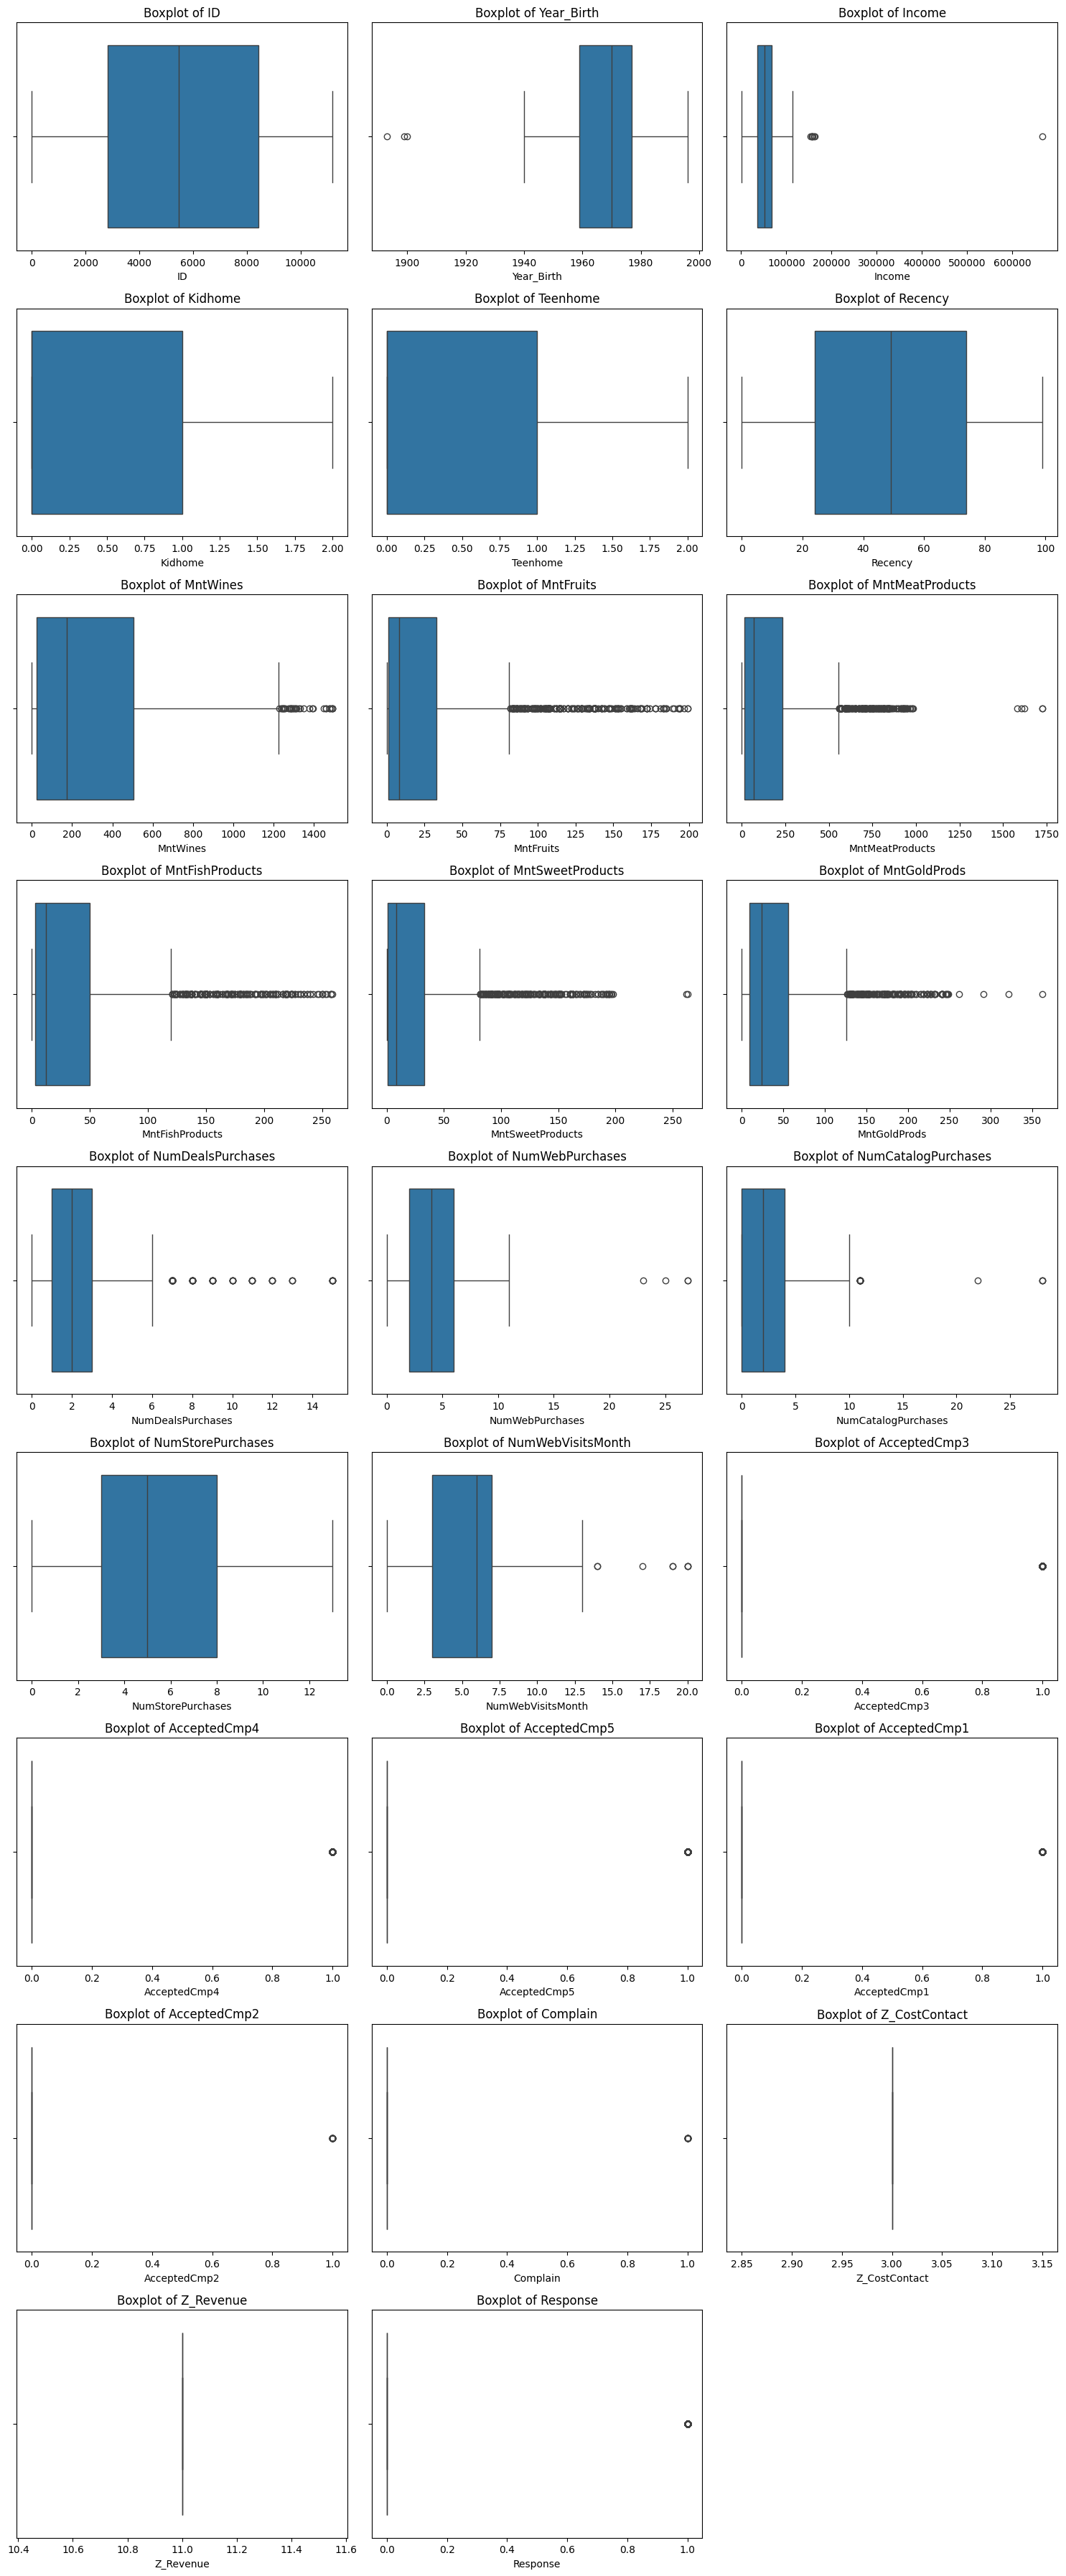

In [9]:
from utils.entrega1.eda import plot_boxplots

plot_boxplots(df, numerical_cols)

#### Variables Categóricas

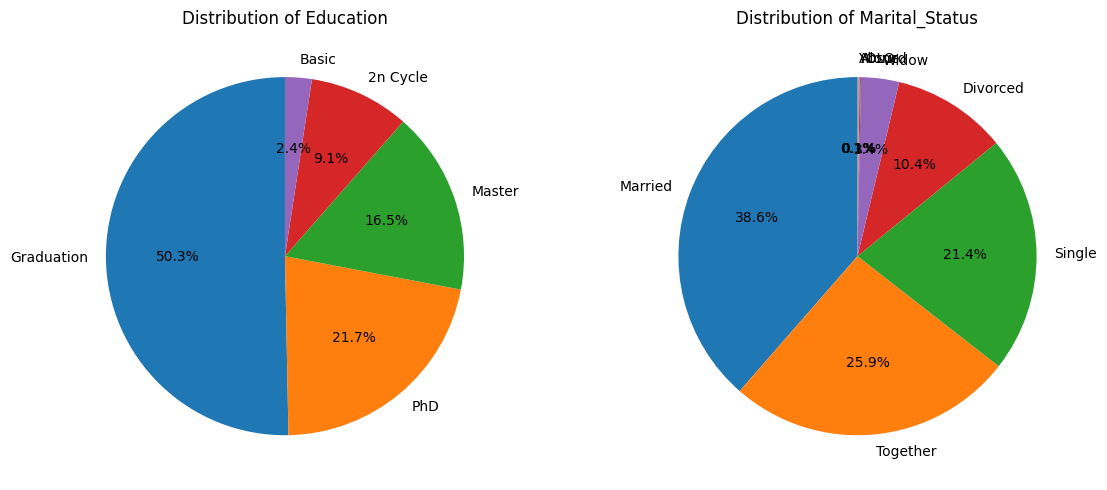

In [10]:
from utils.entrega1.eda import plot_pie_categorical

plot_pie_categorical(df, ['Education', 'Marital_Status'])

#### Matriz de Correlación

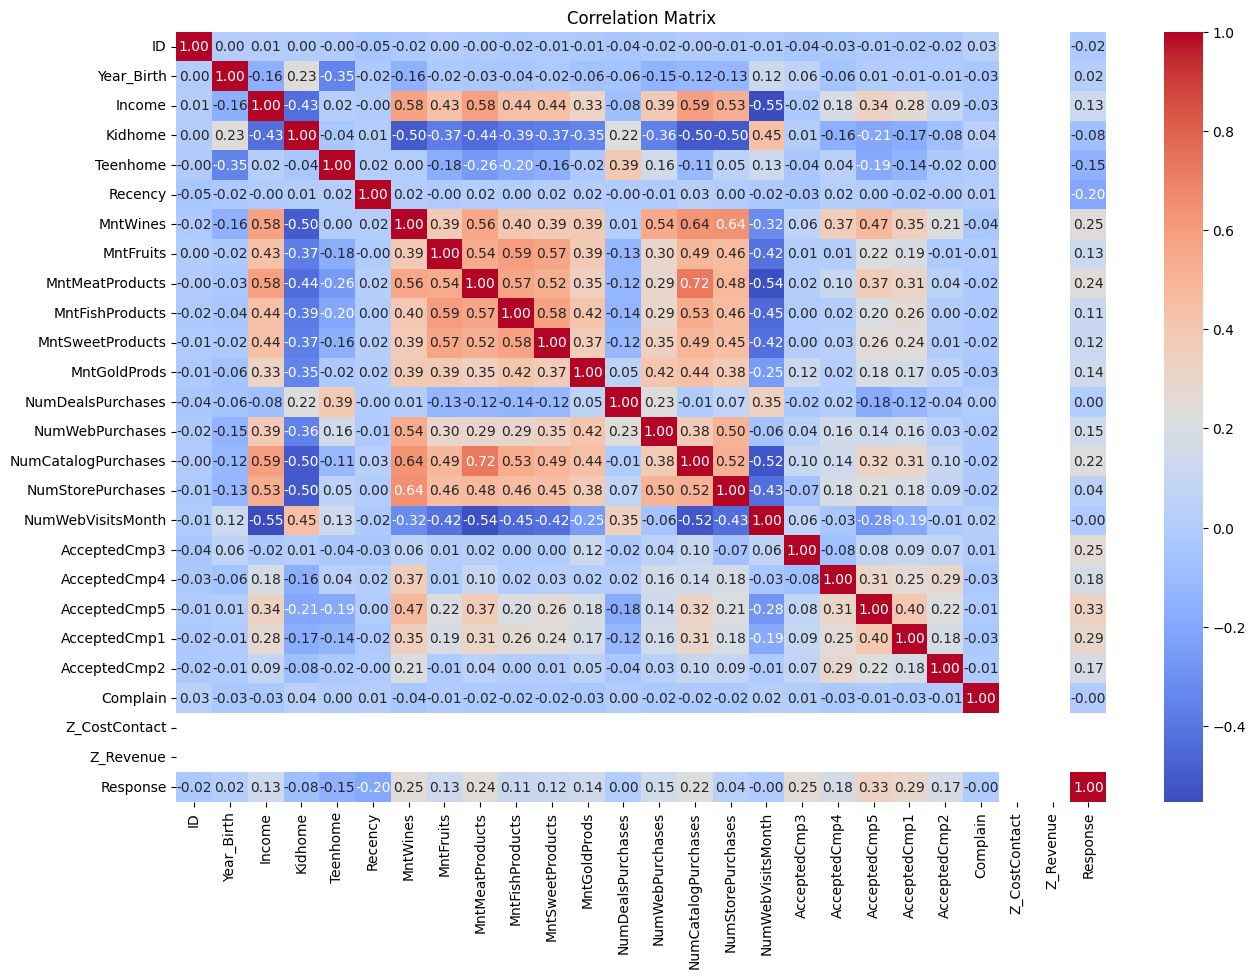

In [11]:
from utils.entrega1.eda import plot_correlation_matrix

plot_correlation_matrix(df)

### 2.3 Preprocesamiento de Datos

Aplicamos el pipeline de preprocesamiento que incluye:
- Manejo de valores faltantes
- Eliminación y transformación de valores atípicos
- Ingeniería de características (Age, Days_Being_Customer, Total_Mnt, etc.)
- Codificación de variables categóricas (One-Hot Encoding)
- Escalado de características numéricas (StandardScaler)

In [12]:
from utils.entrega1.preprocessing import preprocess_pipeline

(
    df_scaled,
    scaler,
    encoder,
    all_feature_cols,
    num_feature_cols,
    ohe_feature_cols,
    categorical_cols,
) = preprocess_pipeline(df)

print(f'Dataset después del preprocesamiento: {df_scaled.shape}')
print(f'Características numéricas: {len(num_feature_cols)}')
print(f'Características OHE: {len(ohe_feature_cols)}')
print(f'Total de características: {len(all_feature_cols)}')

Dataset después del preprocesamiento: (2204, 38)
Características numéricas: 28
Características OHE: 10
Total de características: 38


## 3. Modelado - K-Means

### 3.1 Método del Codo y Silhouette Score

Determinamos el número óptimo de clusters analizando la inercia y el Silhouette Score.
La línea roja punteada indica la hipótesis de negocio (k=3).

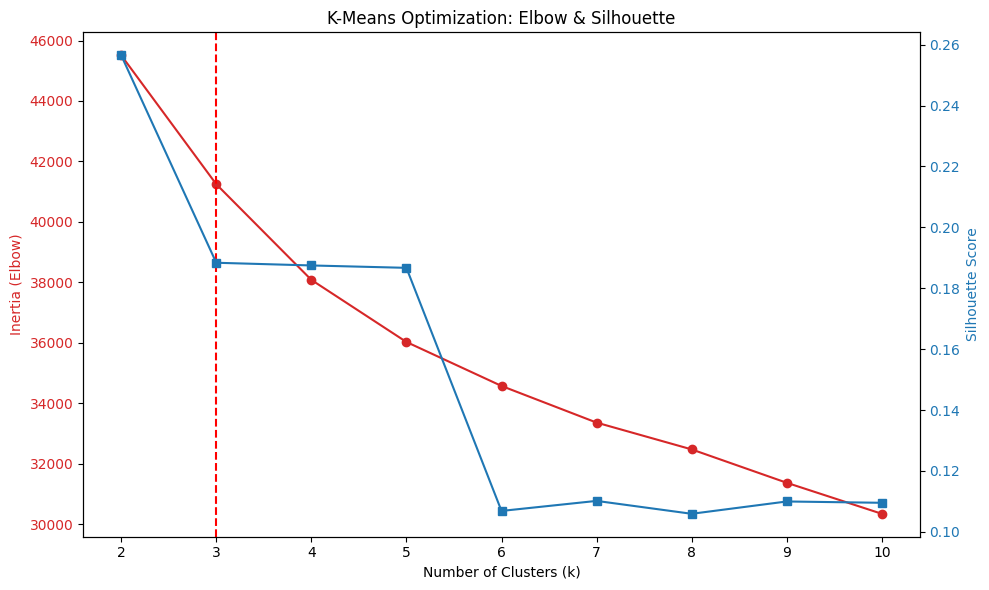

In [13]:
from sklearn.cluster import KMeans
from utils.entrega1.modeling import evaluate_clusters_kmeans

evaluate_clusters_kmeans(
    df_scaled,
    range_n_clusters=range(2, 11),
    include_silhouette=True,
    ref_cluster=3,
)

### 3.2 Entrenamiento del Modelo K-Means Final

In [14]:
n_clusters_kmeans = 3
kmeans_final = KMeans(n_clusters=n_clusters_kmeans, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(df_scaled)

print('K-Means - Distribución de clusters:')
print(pd.Series(kmeans_labels).value_counts().sort_index())

K-Means - Distribución de clusters:
0     502
1    1044
2     658
Name: count, dtype: int64


### 3.3 Interpretación de Clusters K-Means

Analizamos los centroides de cada cluster en su escala original mediante transformación inversa.

In [15]:
# Centros escalados
centers_scaled = pd.DataFrame(kmeans_final.cluster_centers_, columns=all_feature_cols)

# Transformación inversa - numéricas
centers_num_inverse = scaler.inverse_transform(centers_scaled[num_feature_cols])
centers_num_df = pd.DataFrame(centers_num_inverse, columns=num_feature_cols)

# Transformación inversa - categóricas
centers_cat_inverse = encoder.inverse_transform(centers_scaled[ohe_feature_cols])
centers_cat_df = pd.DataFrame(centers_cat_inverse, columns=categorical_cols)

# Combinar
centers_original = pd.concat([centers_num_df, centers_cat_df], axis=1)

print('=== Centroides de K-Means (Escala Original) ===')
display(centers_original.T)

=== Centroides de K-Means (Escala Original) ===


,0,1,2
Income,77294.866534,35143.260536,58848.12766
Kidhome,0.031873,0.782567,0.217325
Teenhome,0.123506,0.451149,0.886018
Recency,50.023904,49.01341,48.424012
MntWines,654.709163,43.786398,455.147416
MntFruits,66.64741,5.024904,29.398176
MntMeatProducts,475.193227,23.772031,150.039514
MntFishProducts,101.707171,7.43295,36.507599
MntSweetProducts,70.944223,5.137931,28.533435
MntGoldProds,77.7251,15.627395,62.81459


## 4. Modelado - Método Jerárquico Aglomerativo (MJA)

### 4.1 Dendrograma

Visualizamos la jerarquía de clusters para determinar el número óptimo de grupos.

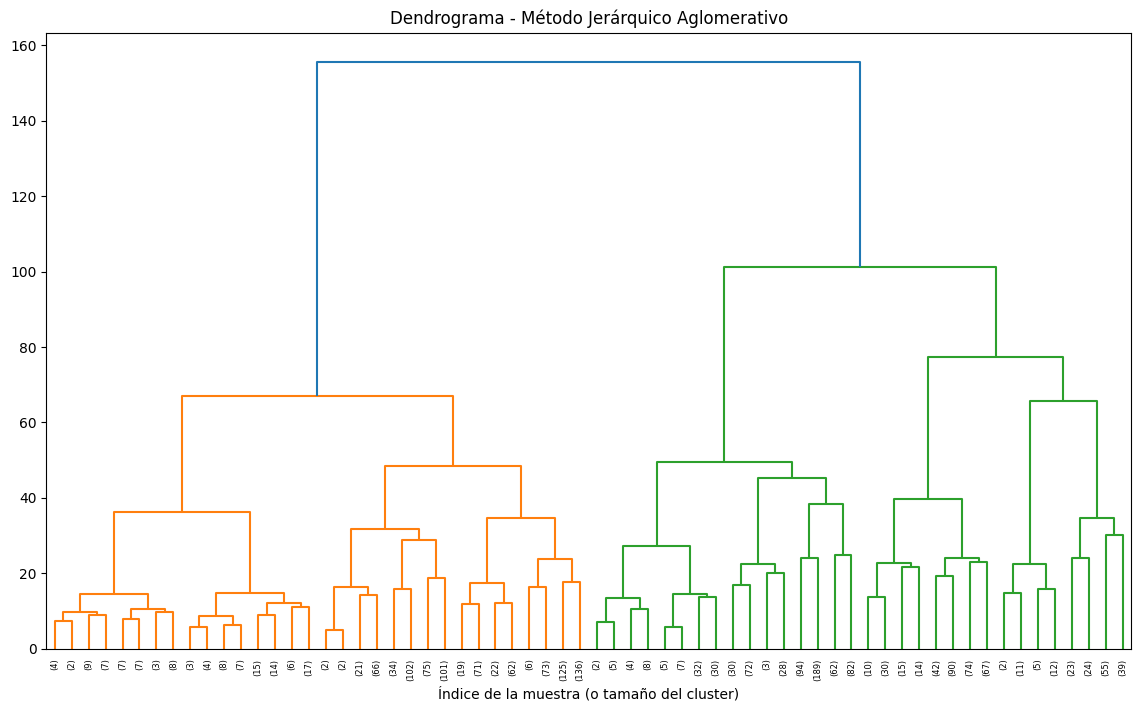

In [16]:
from sklearn.cluster import AgglomerativeClustering
from utils.entrega1.modeling import plot_dendrogram

# Para el dendrograma necesitamos el árbol completo
hierarchical_full = AgglomerativeClustering(
    distance_threshold=0,
    n_clusters=None,
    linkage='ward',
)
hierarchical_full.fit(df_scaled)

plt.figure(figsize=(14, 8))
plt.title('Dendrograma - Método Jerárquico Aglomerativo')
plot_dendrogram(hierarchical_full, truncate_mode='level', p=5)
plt.xlabel('Índice de la muestra (o tamaño del cluster)')
plt.show()

### 4.2 Entrenamiento del Modelo Jerárquico

In [17]:
n_clusters_hierarchical = 3
hierarchical = AgglomerativeClustering(
    n_clusters=n_clusters_hierarchical,
    linkage='ward',
)
hierarchical_labels = hierarchical.fit_predict(df_scaled)

print('MJA - Distribución de clusters:')
print(pd.Series(hierarchical_labels).value_counts().sort_index())

MJA - Distribución de clusters:
0     513
1    1038
2     653
Name: count, dtype: int64


## 5. Modelado - DBSCAN

### 5.1 Estimación de Epsilon (k-NN Distance)

Utilizamos el método del k-NN distance para estimar el valor de epsilon.

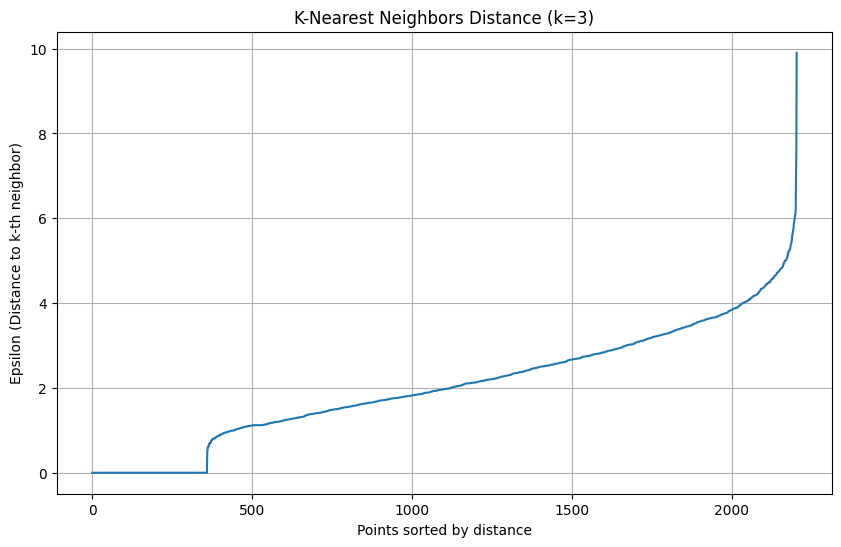

In [25]:
from sklearn.cluster import DBSCAN
from utils.entrega1.modeling import plot_knn_distance, optimize_dbscan_grid

plot_knn_distance(df_scaled, k=3)

### 5.2 Optimización de Hiperparámetros (Grid Search)

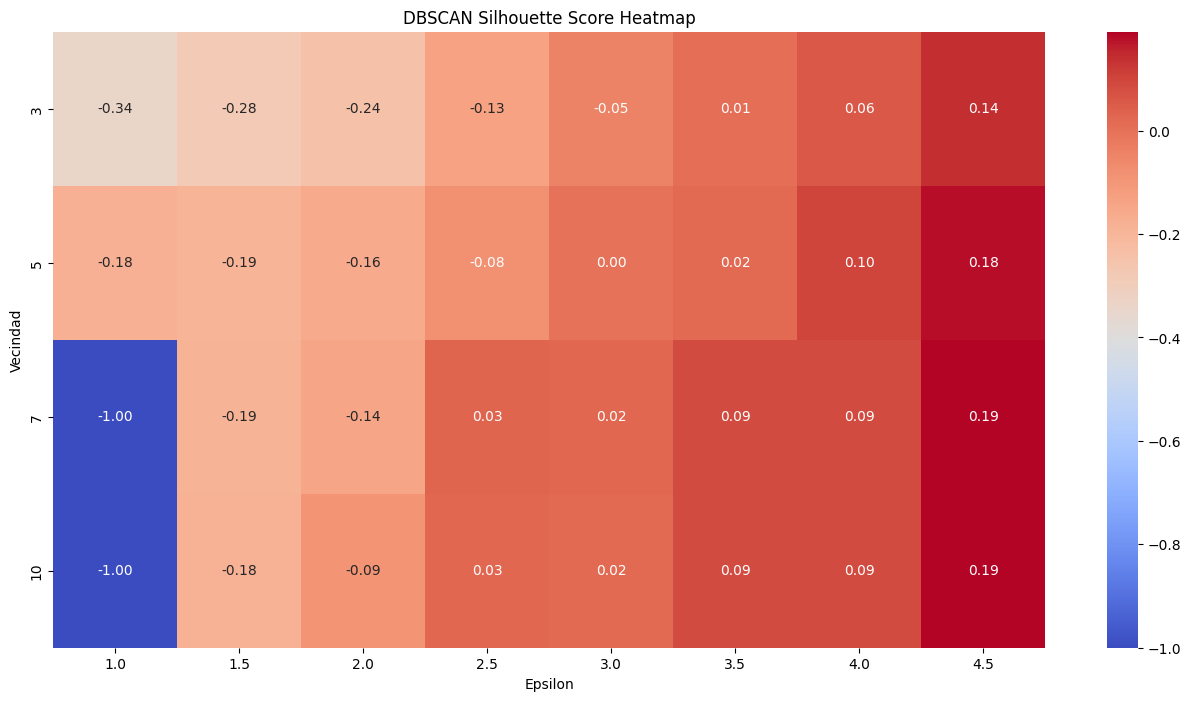

Mejores parámetros: eps=4.5, min_samples=10, score=0.1913


In [19]:
import numpy as np

dbscan_results_df = optimize_dbscan_grid(
    df_scaled,
    eps_values=np.arange(1.0, 5.0, 0.5),
    min_samples_values=[3, 5, 7, 10],
)

# Seleccionar mejores parámetros
best_row = dbscan_results_df.loc[dbscan_results_df['Score'].idxmax()]
best_eps = best_row['Epsilon']
best_min_samples = int(best_row['Vecindad'])
print(f'Mejores parámetros: eps={best_eps}, min_samples={best_min_samples}, score={best_row["Score"]:.4f}')

### 5.3 Entrenamiento del Modelo DBSCAN

In [ ]:
dbscan = DBSCAN(eps=4.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_scaled)

print('DBSCAN - Distribución de clusters:')
print(pd.Series(dbscan_labels).value_counts().sort_index())
print(f'\nPuntos de ruido (label=-1): {(dbscan_labels == -1).sum()}')

DBSCAN - Distribución de clusters:
-1     208
 0    1910
 1      41
 2      14
 3      31
Name: count, dtype: int64

Puntos de ruido (label=-1): 208


## 6. Modelado - Gaussian Mixture Models (GMM)

### 6.1 Selección del Número de Componentes (BIC)

Utilizamos el Criterio de Información Bayesiano (BIC) para determinar el número óptimo de componentes.

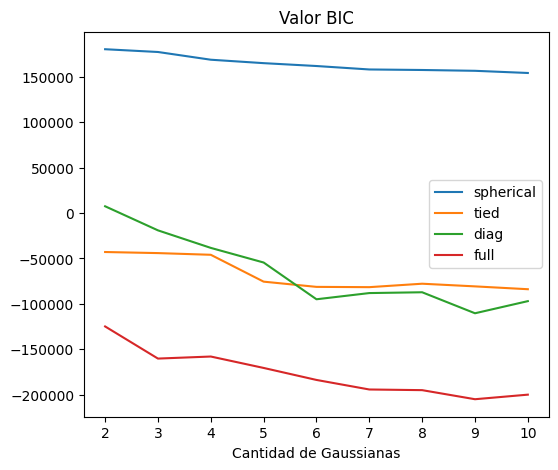

In [21]:
from sklearn.mixture import GaussianMixture
from utils.entrega1.modeling import evaluate_gmm_bic

evaluate_gmm_bic(
    df_scaled,
    n_components_range=range(2, 11),
)

### 6.2 Entrenamiento del Modelo GMM

In [22]:
n_components_gmm = 3
gmm = GaussianMixture(
    n_components=n_components_gmm,
    covariance_type='full',
    random_state=42,
)
gmm_labels = gmm.fit_predict(df_scaled)

print('GMM - Distribución de clusters:')
print(pd.Series(gmm_labels).value_counts().sort_index())

GMM - Distribución de clusters:
0     245
1    1088
2     871
Name: count, dtype: int64


## 7. Comparación de Modelos

### 7.1 Silhouette Score

Comparamos todos los modelos utilizando el Silhouette Score.

In [23]:
from utils.entrega1.modeling import compare_all_models_silhouette

models_dict = {
    'K-Means': kmeans_labels,
    'Jerárquico': hierarchical_labels,
    'DBSCAN': dbscan_labels,
    'GMM': gmm_labels,
}

scores = compare_all_models_silhouette(df_scaled, models_dict)

Silhouette para:
 K-Means: 0.1884
 Jerárquico: 0.1604
 DBSCAN: 0.1913
 GMM: 0.2141


### 7.2 Visualización con PCA

Reducimos la dimensionalidad a 2D para visualizar los clusters de cada modelo.

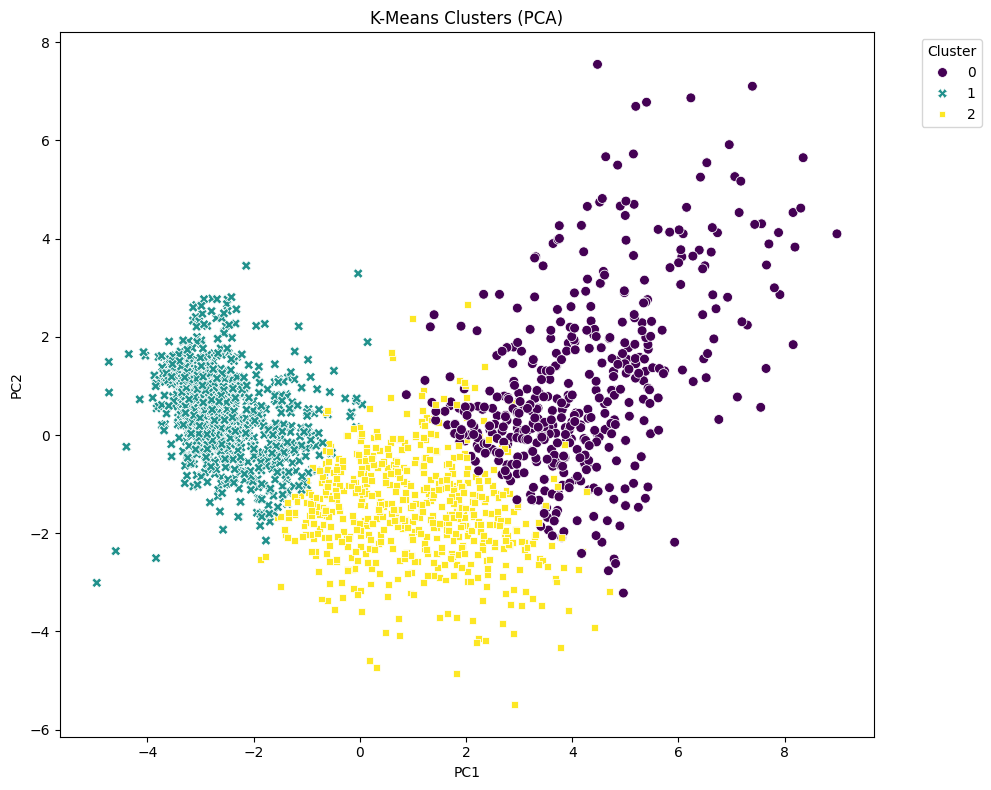

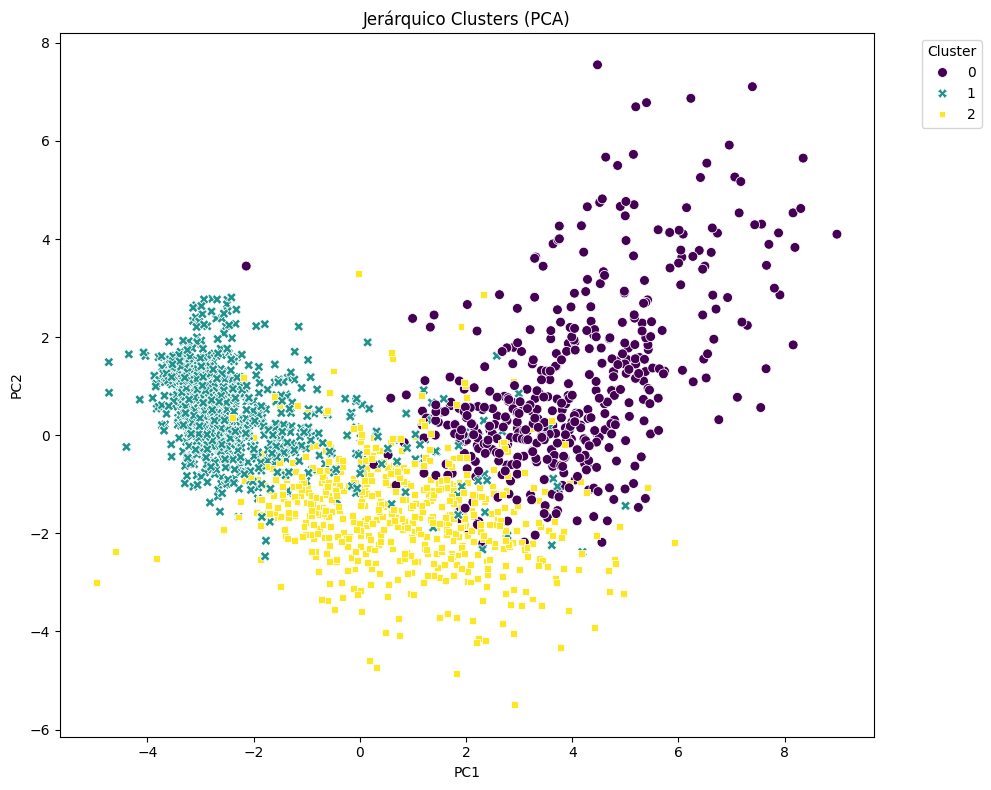

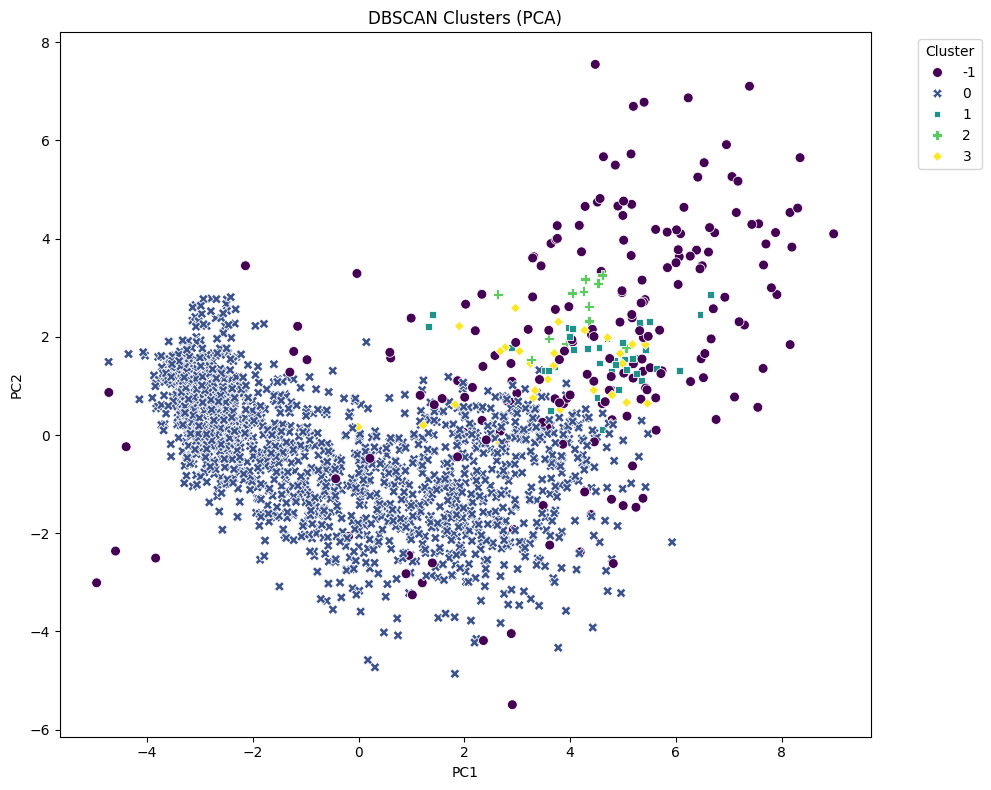

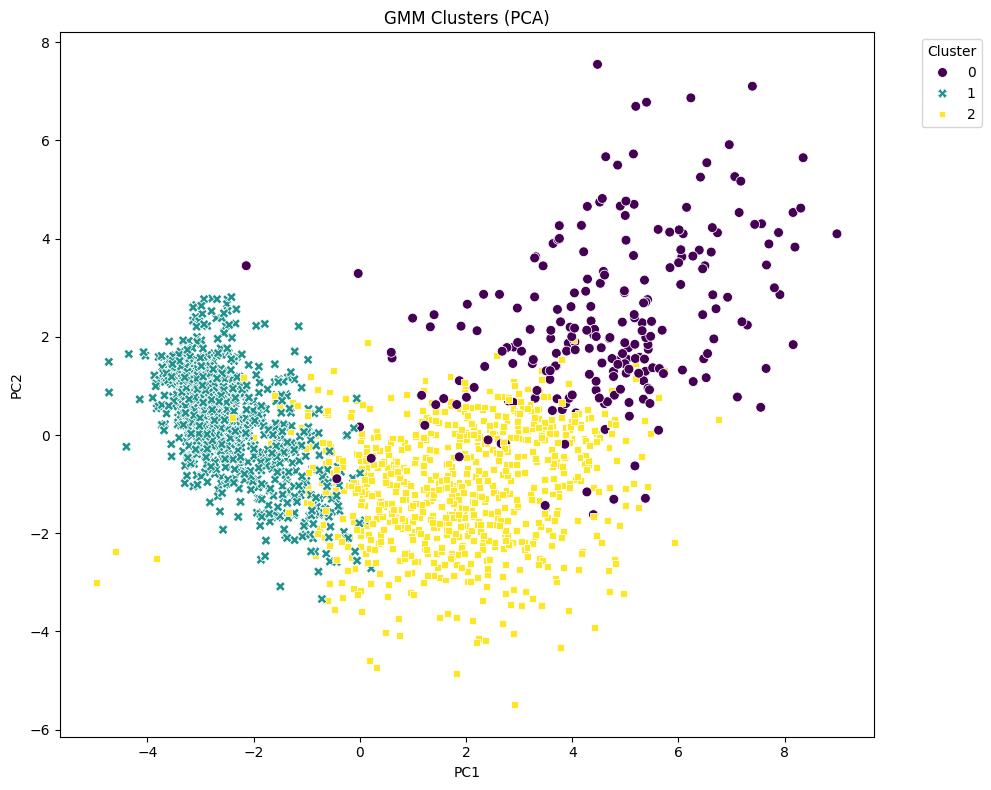

In [24]:
from utils.entrega1.modeling import visualize_clusters_pca

for name, labels in models_dict.items():
    visualize_clusters_pca(df_scaled, labels, title=f'{name} Clusters (PCA)')

## 8. Conclusiones

### 8.1 Resumen de Resultados

Basándonos en el análisis realizado:

1. **K-Means** y **Método Jerárquico** confirman la hipótesis de negocio de 3 clusters
2. **DBSCAN** identifica clusters basados en densidad y puede detectar outliers
3. **GMM** proporciona asignación probabilística a los clusters

### 8.2 Recomendaciones

- El modelo **K-Means** es recomendado por su simplicidad e interpretabilidad
- Los 3 clusters identificados permiten estrategias de marketing diferenciadas
- Se recomienda validar los resultados con el equipo de negocio